# Complete exploration of first names Biases in NER models

Following the same general methode explained in this [article](https://arxiv.org/pdf/2008.03415.pdf), we construct a small datasets with first names associated with ethnicity. 

This notebook is made to explore the possible biases in NER models when applied to the detection of first names. 

Firstly, we will compute the same thing as in the article, then, we will go further by exploring the same hypothesis but with other datasets. 

For each exploration, 4 models will be used: 
- sm
- md
- lg
- trf


We are only testing if the first names are recognized as named entities by the models, but not if they are actually recognized as a person's name. 

This could have been done by using this kind of code : 

`doc.ents[0].label_`

And this would constitute a good improvement of this project, because maybe we could have seen ome other biases - or not - in the label, and could also have defined a different metric. 

But again, here, we are just giving a score of 1 if the name has been recognized and 0 if not. 

Then, we can have a mean results for each of the first names and finally have the results for each group. 

**Steps of this notebook :**
1. **Utils**

The first part of this notebook can be found quite technical. It consists in the developement of several functions used afterwards on all the datasets. 

- Those functions are made to: 
    - Computing the sentences
    - Applying the four models 
    - Getting back the results in a proper way

For all of the expirements of this notebook and in order to construct the sentences, we are using the winogender schemas described in the article. 

Depending on the datasets, some other function are needed, for instance to average the results given the popularity of a first name depending on the birth year on the US baby names dataset. But this last point is developped in the needed parts of this notebook. 

You can find a more detailed explanation about the datasets used and the methodology on [this GitHub page](https://adrihans.github.io/Decoding_NER_Biases/).

## Necessary imports:

In [2]:
import geopandas as gpd

import pandas as pd
import numpy as np

from tqdm import tqdm
import random


#Viz:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Spacy:
import spacy
from spacy import displacy

## Utils

### Winogender

We also have to build templates for the sentences. 

Just as in the article, we're using the winogender schemas, which was made to check gender biases in algorithmic procedures. The project consists in basic sentences, with some variables like : `$Participant`, `$Occupation` or `$Pronoun`, which can then be replaced by actual names. 

The github page of the project can be found [here](https://github.com/rudinger/winogender-schemas), and the page of the templates we're using can be found [here](https://github.com/rudinger/winogender-schemas/blob/master/data/templates.tsv). 

In [3]:
#Accessing the templates : 
templates_sentences = pd.read_csv('https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/templates.tsv', sep='\t')

In [4]:
templates_sentences.shape

(120, 4)

We have to make some modifications because the templates were not actually intended to be used with actual first names. 

For instance, There is often `The` before the word `$Occupation` - because it was intended to used with an occupation. 

Then, we have to delete this 'the' when it is present. 

We also have to check if there are indeed 3 possible names in each sentence, and if the pronoun is a nominative one -to avoid any english mistake. 

In [5]:
#We need to delete the 'THE' before occupation and participant :
def make_template_right(sent):    
    l_sent = sent.split()
    i_occupation = l_sent.index('$OCCUPATION')
    if i_occupation != 0: 
        if l_sent[i_occupation-1].lower() == 'the': 
            del l_sent[i_occupation-1]

    #Same thing with $PARTICIPANT : 

    i_participant = l_sent.index('$PARTICIPANT')
    if i_participant != 0: 
        if l_sent[i_participant-1].lower() == 'the': 
            del l_sent[i_participant-1]

    #Building up the sentence again: 
    return ' '.join(l_sent)

In [6]:
#Applying the function to the dataframe: 
tqdm.pandas()
templates_sentences['right_sentence'] = templates_sentences['sentence'].progress_apply(make_template_right)

100%|█████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 39606.27it/s]


In [7]:
#We only take into account the nomitative pronouns to form exact sentences:
def check_three_items(sentence):
    if '$OCCUPATION' in sentence:
        if '$PARTICIPANT' in sentence:
            if '$NOM_PRONOUN' in sentence:
                return 1
    return 0 

In [8]:
#Applying the function described above and selecting only the sentences with three items:
templates_sentences['three_items'] = templates_sentences['right_sentence'].apply(check_three_items)
templates_sentences = templates_sentences[templates_sentences['three_items']==1]

In [9]:
t=templates_sentences.sample(1)

In [10]:
t['sentence'].values[0]

'The $PARTICIPANT was referred to the $OCCUPATION because $NOM_PRONOUN had a rare skin condition.'

In [11]:
t['right_sentence'].values[0]

'$PARTICIPANT was referred to $OCCUPATION because $NOM_PRONOUN had a rare skin condition.'

In [12]:
templates_sentences.shape[0]

89

### Function to compute sentences

In [13]:
#In each template sentence, there are : 
# $OCCUPATION // $PARTICIPANT  // $NOM_PRONOUN
#Then, we just have to replace each thing with a first name.

def compute_random_sentences(row, arr_names, template=templates_sentences):
    """
    The template has to have a column 'right_sentence'
    """    
    #Firstly we need to take one sentence at random:
    str_sentence = template.sample(1)['right_sentence'].values[0]
    #The names should not be all the same: 
    random_occupation = random.choice(arr_names)
    random_participant=random_occupation
    while random_occupation == random_participant:
        random_participant = random.choice(arr_names)
    random_pronoun = random_occupation
    while random_pronoun == random_occupation or random_pronoun == random_participant:
        random_pronoun = random.choice(arr_names)
           
    
    #we replace the right words to form the finale sentence: 
    str_sentence=str_sentence.replace('$OCCUPATION', random_occupation)
    str_sentence=str_sentence.replace('$PARTICIPANT', random_participant)
    str_sentence=str_sentence.replace('$NOM_PRONOUN', random_pronoun)
    return str_sentence, random_occupation, random_participant, random_pronoun

### Models

We are using spacy to test the NER algorithms.

We are testing the 4 models implemented in version 3.1 of Spacy: 

- sm
- md
- lg
- trf

We load the four models at once:

In [14]:
nlp_sm = spacy.load("en_core_web_sm")
nlp_md = spacy.load("en_core_web_md")
nlp_lg = spacy.load("en_core_web_lg")
nlp_trf = spacy.load("en_core_web_trf")

C:\Users\adrie\Anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\adrie\Anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\adrie\Anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_lg' (3.1.0) was tra

In [15]:
def predict_NER_spacy(text, model):
    """
    This function just consists in applying a given NER model to a given text. 
    
    @Inputs:
        text: str, the text the model is applied on
        
        model: str, the model to be used, either:
                - 'sm'
                - 'md'
                - 'lg'
                - 'trf'
    @Outputs:
        - predicted_label_liste, list, the list of the named entities recognized by the specified model. 
    """
    if model=='sm':
        doc=nlp_sm(text)
    elif model=='md':
        doc=nlp_md(text)
    elif model=='lg':
        doc=nlp_lg(text)
    elif model=='trf':
        doc=nlp_trf(text)
    else:
        return np.nan
        
    predicted_label_liste=[str(ent).strip() for ent in doc.ents]
    return predicted_label_liste

### Was the name found?

In [16]:
#Is the name found ?? 
def check_names_prediction(row):
    """
    Function check_names_prediction
    
    @Inputs:
        - row of a dataframe cointaing at least 4 columns: 
            - '0', '1' and '2': specifying the three persons names.
            - 'spacy_prediction': the prediction of the model. 
                See the function main_ner_first_names for more detailed information. 
    @Outputs:
        - var_0, var_1, var_2, int, either 0 or 1, specifying if the name n has been recognized(1) or not(0).
    """
    var_0, var_1, var_2 = 0,0,0
    if row['0'] in row['spacy_prediction']:
        var_0 = 1
    if row['1'] in row['spacy_prediction']:
        var_1 = 1
    if row['2'] in row['spacy_prediction']:
        var_2 = 1    
    return var_0, var_1, var_2

### Computing the stats:

In [17]:
def compute_stats_names(df_test_names, model):
    """
    Model is a str of the name of the model
    
    """
    #Creating a new dataframe:
    df_temp=pd.DataFrame()
    df_temp['score_'+model] = pd.concat([df_test_names['0_found'], df_test_names['1_found'], df_test_names['2_found']])
    df_temp['name'] = pd.concat([df_test_names['0'], df_test_names['1'], df_test_names['2']])
    #We then have one 'mean' score per name:
    df_temp = df_temp.groupby('name').agg({'score_'+model:'mean'}).reset_index(drop=False)
    return df_temp

### main():

In [18]:
def main_ner_first_names(n_sentences, arr_names, template=templates_sentences):
    """
    In this function, we are computing the sentences, applying the model. 
    
    Then, each name has a 'mean' score. 
    """
    #We are computing the sentences, given the arr_names and the number of sentences:
    df_test_names = pd.DataFrame(index=range(n_sentences))
    df_test_names['tt']= 1 
    df_test_names['sentence'], df_test_names['0'], df_test_names['1'], df_test_names['2'] = zip(*df_test_names.apply(lambda x: compute_random_sentences(x, arr_names, template), axis=1))
    del df_test_names['tt']
    
    
    
    #We define the df of the results:
    df_results=pd.DataFrame(data={'name':arr_names})
    
    #Then, we apply the models:
    for model in ['sm', 'md', 'lg', 'trf']:
        
        print('Testing the model: '+model)
        
        
        tqdm.pandas()
        df_test_names['spacy_prediction'] = df_test_names['sentence'].progress_apply(lambda x: predict_NER_spacy(x, model))
        #We replace the list with a string, because otherwise for a list like : [Emily if Camila], neither Emily or Camila 
        #Would be mark as 1 by the test above. 
        df_test_names['spacy_prediction'] = df_test_names['spacy_prediction'].apply(lambda l : ' '.join(l))
        #We apply the function to check if the names were understood as NER by the model: 
        df_test_names['0_found'], df_test_names['1_found'], df_test_names['2_found'] = zip(*df_test_names.apply(check_names_prediction, axis=1))
        #computing the stats:
        #And merging with the results df:
        df_results = df_results.merge(compute_stats_names(df_test_names, model), left_on='name', right_on='name', how='right')
        

    return df_results

## Names based on the article

We are here using the names described in [that article](https://arxiv.org/pdf/2008.03415.pdf).

We are using the exact same names as in the article. 

Each category is composed of 15 names. 

### Constructing the dataset

In [19]:
#Black Female = BF_names
BF_names = ['Aaliyah', 'Ebony', 'Jasmine', 'Lakisha', 'Latisha',
'Latoya', 'Malika', 'Nichelle', 'Nishelle', 'Shanice',
'Shaniqua', 'Shereen', 'Tanisha', 'Tia', 'Yolanda','Yvette']
#Black Male = BM_names
BM_names = ['Alonzo', 'Alphonse', 'Darnell', 'Deion', 'Jamel',
'Jerome', 'Lamar', 'Lamont', 'Leroy', 'Lionel', 'Malik',
'Terrence', 'Theo', 'Torrance', 'Tyree']
#Hispanic Female = HF_names
HF_names=['Ana', 'Camila', 'Elena', 'Isabella', 'Juana', 'Luciana', 'Luisa', 'Maria', 'Mariana', 'Martina', 'Sofia',
'Valentina', 'Valeria', 'Victoria', 'Ximena']
#Hispanic Male = HM_names
HM_names = ['Alejandro', 'Daniel', 'Diego', 'Jorge', 'Jose', 'Juan',
'Luis', 'Mateo', 'Matias', 'Miguel', 'Nicolas', 'Samuel',
'Santiago', 'Sebastian', 'Tomas']
#Muslim Female = MF_names
MF_names = ['Alya', 'Ayesha', 'Fatima', 'Jana', 'Lian', 'Malak',
'Mariam', 'Maryam', 'Nour', 'Salma', 'Sana', 'Shaista',
'Zahra', 'Zara', 'Zoya']
#Muslim Male = MM_names
MM_names = ['Abdullah', 'Ahmad', 'Ahmed', 'Ali', 'Ayaan', 'Hamza',
'Mohammed', 'Omar', 'Rayyan', 'Rishaan', 'Samar',
'Syed', 'Yasin', 'Youssef', 'Zikri']
#White Female = WF_names
WF_names = ['Amanda', 'Betsy', 'Colleen', 'Courtney', 'Ellen',
'Emily', 'Heather', 'Katie', 'Kristin', 'Lauren', 'Megan',
'Melanie', 'Nancy', 'Rachel', 'Stephanie']
#White Male = WM_names
WM_names = ['Adam', 'Alan', 'Andrew', 'Brad', 'Frank', 'Greg',
'Harry', 'Jack', 'Josh', 'Justin', 'Matthew', 'Paul', 'Roger',
'Ryan', 'Stephen']


#Defining the list of origins:
list_origins = ['BF_names', 'BM_names', 'HF_names', 'HM_names', 'MF_names', 'MM_names',
               'WF_names', 'WM_names']

#Defining the Datafram 'df_complete_names' with two columns - 'name' and 'origin' - containing every first names
df_complete_names = pd.DataFrame(columns=['name', 'origin'])
for origin in list_origins: 
    df_temp = pd.DataFrame()
    df_temp['name'] = globals()[origin]
    df_temp['origin'] = origin
    df_complete_names = pd.concat([df_complete_names, df_temp])
df_complete_names.reset_index(drop=True, inplace=True)

In [20]:
df_complete_names.head()

,name,origin
0,Aaliyah,BF_names
1,Ebony,BF_names
2,Jasmine,BF_names
3,Lakisha,BF_names
4,Latisha,BF_names


In [21]:
#Constructing the array of the unique names:
arr_names_article=df_complete_names['name'].unique()

### Results

We are then applying the function `main_ner_first_names` on those names, with a number of computed sentences.

**Why are we not using every possible sentences - with every possible permutations ?**

```
Since there are 89 unique template sentences, and 121 unique names in total, we would have 1 727 880 3-ordered permutation of every names. 

Thus 89 * 1 727 880 =  153 781 320 sentences we should apply the models on. 
```

Even if doing so would have been a bit better because it would have given us reproductible results, we do not have access to enough computational ressources.

Then, what we are doing is picking randomly 3 different first names from the dataframe, and picking one sentence. 

But in order to conterbalance this randomness, we are doing this on a large amont of sentences. 

In [21]:
df_results_article = main_ner_first_names(100000, arr_names_article)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:19<00:00, 178.75it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:34<00:00, 174.06it/s]


Testing the model: lg


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:37<00:00, 173.08it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:40:37<00:00, 16.56it/s]


In [22]:
#Saving and visualising the results:
#df_results_article.to_csv('data/results/first_names/df_results_article_100000.csv', index=False)
df_results_article=pd.read_csv('data/results/first_names/df_results_article_100000.csv')
df_results_article.head()

,name,score_sm,score_md,score_lg,score_trf
0,Aaliyah,0.892011,1.000000,1.000000,0.974709
1,Abdullah,1.000000,1.000000,1.000000,0.995556
2,Adam,0.066640,0.034318,0.011572,0.854749
3,Ahmad,0.999190,1.000000,0.999595,0.993520
4,Ahmed,0.966496,1.000000,0.998423,0.996847


### Viz

In [23]:
list_female = ['WF_names', 'BF_names', 'HF_names', 'MF_names']
list_male = ['WM_names', 'HM_names', 'BM_names', 'MM_names']

#Get ethnicity and gender for each name:
def compute_gender(origin):
    if origin in list_female:
        return 'male'
    else:
        return 'female'
    
def compute_ethnicity(origin):
    if origin in ['WF_names', 'WM_names']:
        return 'white'
    elif origin in ['BF_names', 'BM_names']:
        return 'black'
    elif origin in ['MF_names', 'MM_names']:
        return 'muslim'
    else:
        return 'hispanic'

df_results_article = df_results_article.merge(df_complete_names, left_on='name', right_on='name', how='left')
df_results_article['ethnicity'] = df_results_article['origin'].apply(compute_ethnicity)
df_results_article['gender'] = df_results_article['origin'].apply(compute_gender)

In [24]:
df_results_article_gb = df_results_article.groupby(['ethnicity', 'gender']).agg({'score_sm':'mean', 'score_md':'mean', 'score_lg':'mean', 'score_trf':'mean'})
#Compute the average score for all the models:
df_results_article_gb['avg_score']=df_results_article_gb[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

#### General results

In [25]:
df_results_article_gb.style.highlight_max(color='#e6ffe6').highlight_min(color='#ffe6e6')

In [26]:
df_results_article_gb.style.background_gradient(cmap='PiYG')

#### Results based on the ethnicity

In [27]:
df_results_article_gb.groupby('ethnicity').mean().style.background_gradient(cmap='PiYG')

,score_sm,score_md,score_lg,score_trf,avg_score
ethnicity,,,,,
black,0.629856,0.883771,0.939347,0.942000,0.848743
hispanic,0.698746,0.953401,0.953712,0.959077,0.891234
muslim,0.776677,0.924060,0.835094,0.978691,0.878631
white,0.789193,0.885961,0.900822,0.936218,0.878049


#### Results based on the gender

In [28]:
df_results_article_gb.groupby('gender').mean().style.background_gradient(cmap='PiYG')

,score_sm,score_md,score_lg,score_trf,avg_score
gender,,,,,
female,0.693836,0.894033,0.895380,0.941845,0.856273
male,0.753401,0.929563,0.919108,0.966148,0.892055


## US Baby names - national level

### Importing the dataset

In [29]:
df_us_names = pd.read_csv('Data/us_baby_names/NationalNames.csv')

In [30]:
del df_us_names['Id']
df_us_names.head()

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Anna,1880,F,2604
2,Emma,1880,F,2003
3,Elizabeth,1880,F,1939
4,Minnie,1880,F,1746


In [31]:
df_us_names['Year'].max()

2014

In [32]:
df_us_names['Name'].nunique()

93889

There are a lot of names in the dataframe, thus we're only taking the n most popular names for each year and each gender:

In [33]:
#df_us_names[df_us_names['Count']>1000].sample(100, random_state=42).sort_values('Year').head()
arr_us_names = df_us_names.groupby(['Year','Gender'])[['Count', 'Name']].apply(lambda x: x.nlargest(10, columns=['Count']))['Name'].unique()
print('total number of names considered:', arr_us_names.shape[0])
#Also computing the total list of years:
liste_years = df_us_names.sort_values('Year')['Year'].unique()

total number of names considered: 129


### Results

In [30]:
df_results_us = main_ner_first_names(100000, arr_us_names)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:09<00:00, 204.21it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:03<00:00, 184.03it/s]


Testing the model: lg


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:01<00:00, 184.78it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:31:42<00:00, 18.17it/s]


In [35]:
#Saving the results:
#df_results_us.to_csv('data/results/first_names/df_results_us_nation_100000.csv', index=False)
#Accesing the results:
df_results_us = pd.read_csv('data/results/first_names/df_results_us_nation_100000.csv')
df_results_us.head()

,name,score_sm,score_md,score_lg,score_trf
0,Abigail,0.999143,1.000000,1.000000,0.763068
1,Aiden,0.487489,0.678602,0.984469,0.901639
2,Alexander,0.635550,0.995311,1.000000,0.867860
3,Alexis,0.701769,0.975990,0.994524,0.915754
4,Alice,0.671692,1.000000,1.000000,0.954355


In [36]:
#Getting the array of the names really used inside the algorithm:
new_us_names=df_results_us['name'].unique()

In [37]:
def compute_score_year(year, model):
    n_people = 0
    dict_sum_scores = {'sm': 0, 'md':0, 'lg':0, 'trf':0}
    for name in new_us_names:
        try:
            df_temp_year = df_us_names[df_us_names['Year']==year]
            n=df_temp_year[df_temp_year['Name']==name]['Count'].values[0]
            n_people+=n
            for model in ['sm', 'md', 'lg', 'trf']:
                dict_sum_scores[model] += df_results_us[df_results_us['name']==name]['score_'+model].values[0]*n
        except:
            n_people+=0
    return {k:v/n_people for k,v in dict_sum_scores.items()}

In [38]:
#Averaging the score on the years:
    #Defining the dataframe:
df_us_final_results = pd.DataFrame(data = {'year':liste_years})
    #Getting the scores:
tqdm.pandas()

for model in ['sm', 'md', 'lg', 'trf']:
    df_us_final_results['d']= df_us_final_results['year'].progress_apply(lambda x: compute_score_year(x, model))
    df_us_final_results['score_'+model] = df_us_final_results['d'].apply(pd.Series)[model]
del df_us_final_results['d']

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [02:10<00:00,  1.03it/s]


Computing the average score:

In [39]:
#We are computing the average score of the models:
df_us_final_results['avg_score']=df_us_final_results[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [40]:
df_us_final_results.head()

,year,score_sm,score_md,score_lg,score_trf,avg_score
0,1880,0.792332,0.913002,0.969546,0.865559,0.885109
1,1881,0.807298,0.924330,0.980426,0.872076,0.896032
2,1882,0.785082,0.914942,0.971416,0.867883,0.884831
3,1883,0.799331,0.924311,0.976894,0.870924,0.892865
4,1884,0.787200,0.920353,0.975658,0.869222,0.888108


### Viz

Plotting the results of all the models. 

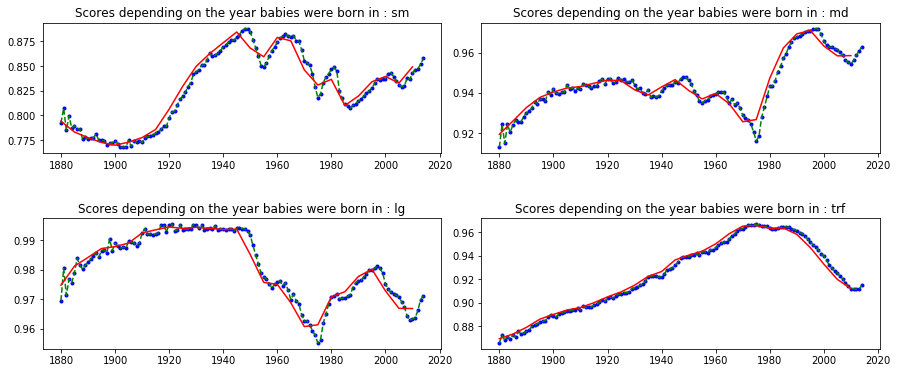

In [42]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i in range(4):
    model = ['sm','md','lg','trf'][i]
    #Computing the mean scores by range of every 5 years:
    arr=df_us_final_results['score_'+model].values
    y_mean_5=np.mean(arr.reshape(-1, 5), axis=1)
    x_mean_5=np.array([x for x in range(1880, 2015, 5)])


    x=df_us_final_results['year']
    y= df_us_final_results['score_'+model]


    #Defining the figure:
    axs[i].set_title('Scores depending on the year babies were born in : ' + model)
    axs[i].plot(x, y, 'o', color='b', markersize=3, label='raw')
    axs[i].plot(x, y, '--', color='g', markersize=3, label='line')
    axs[i].plot(x_mean_5, y_mean_5, color = 'r', label='mean for every 5y')
    
plt.savefig('images/results/score_each_models_first_names_year.png', bbox_inches='tight')
plt.show()

Average score of the 4 models:

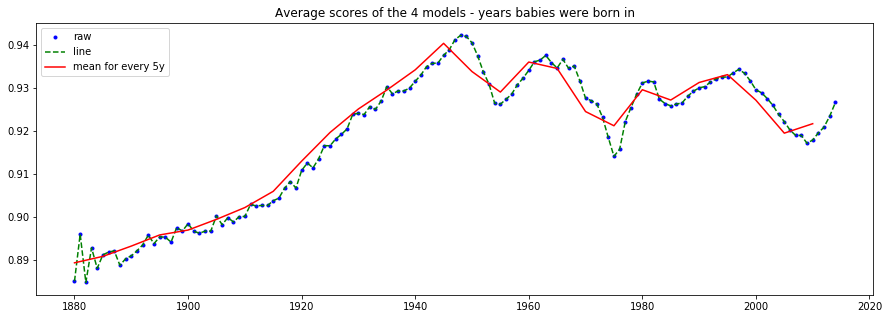

In [43]:
x=df_us_final_results['year']
y=df_us_final_results['avg_score']
y_mean_5=np.mean(y.values.reshape(-1, 5), axis=1)
x_mean_5=np.array([x for x in range(1880, 2015, 5)])

fig= plt.figure(figsize=(15,5))
plt.title('Average scores of the 4 models - years babies were born in')
plt.plot(x, y, 'o', color='b', markersize=3, label='raw')
plt.plot(x, y, '--', color='g', markersize=3, label='line')
plt.plot(x_mean_5, y_mean_5, color = 'r', label='mean for every 5y')
plt.legend()
plt.savefig('images/results/avg_score_first_names_year.png', bbox_inches='tight')
plt.show()

In [44]:
df_us_final_results.sort_values('avg_score', ascending=False)[['year', 'avg_score']].head(5)

,year,avg_score
68,1948,0.942201
69,1949,0.941947
67,1947,0.941186
70,1950,0.940492
66,1946,0.938860


The best results then correspond to the years just afte WW2.

We can do the same kind of things depending on the age of people:

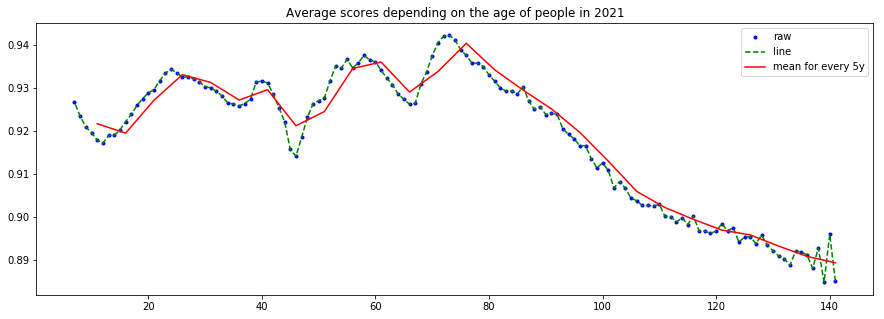

In [46]:
fig= plt.figure(figsize=(15,5))
plt.title('Average scores depending on the age of people in 2021')
plt.plot(2021-x, y, 'o', color='b', markersize=3, label='raw')
plt.plot(2021-x, y, '--', color='g', markersize=3, label='line')
plt.plot(2021-x_mean_5, y_mean_5, color = 'r', label='mean for every 5y')
plt.savefig('images/results/avg_score_first_names_year_AGE.png', bbox_inches='tight')
plt.legend()
plt.show()

## NYC

We're using the NYC dataset with ethnicity in it to go further than the article. 

### Importing and cleaning the dataframe

In [48]:
df_nyc_names = pd.read_csv('Data/NYC_Popular_Baby_Names.csv')

In [49]:
df_nyc_names.head()

,Year of Birth,Gender,Ethnicity,Child's First Name,Count,Rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42
3,2011,FEMALE,HISPANIC,GISELLE,38,51
4,2011,FEMALE,HISPANIC,GRACE,36,53


In [50]:
#Some names are not written in the same way, so we title them all:
df_nyc_names["Child's First Name"]= df_nyc_names["Child's First Name"].str.title()

#There are also some mistakes in the way the ethnicity is written: 
d_replace_ethnicity = {"ASIAN AND PACI" : 'ASIAN AND PACIFIC ISLANDER', 
            "BLACK NON HISP" : "BLACK NON HISPANIC", 
            "WHITE NON HISP" : "WHITE NON HISPANIC"}


df_nyc_names["Ethnicity"]=df_nyc_names["Ethnicity"].replace(d_replace_ethnicity)

#We sum up the count for each first name -depending on the gender and ethnicity-:
df_nyc_names=df_nyc_names.groupby(["Child's First Name", "Ethnicity", "Gender"]).agg({'Count':'sum'}).reset_index(drop=False)

In [51]:
#There are too much names, Thus:
#We are taking the 10 most common names for each ethnicity and each gender:
arr_nyc_names = df_nyc_names.groupby(['Ethnicity','Gender'])[['Count', "Child's First Name"]]\
.apply(lambda x: x.nlargest(10, columns=['Count']))["Child's First Name"].unique()

In [52]:
arr_nyc_names.shape

(58,)

### Results

In [18]:
df_results_nyc = main_ner_first_names(100000, arr_nyc_names)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:26<00:00, 176.47it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [11:22<00:00, 146.47it/s]


Testing the model: lg


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [15:34<00:00, 107.02it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:53:35<00:00, 14.67it/s]


In [53]:
#df_results_nyc.to_csv('data/results/first_names/df_results_nyc_100000.csv', index=False)
df_results_nyc=pd.read_csv('data/results/first_names/df_results_nyc_100000.csv')

Then, we have a score for each first name. 

In [55]:
#Getting the array of the names actually used by the model:
new_names_nyc = df_results_nyc['name'].unique()

#### Ethnicity:

In [56]:
#Getting the complete list of ethnicities inside the dataframe:
liste_ethnicity = df_nyc_names['Ethnicity'].unique()

In [57]:
def compute_score_ethnicity(ethnicity):
    n_people = 0
    dict_sum_scores = {'sm': 0, 'md':0, 'lg':0, 'trf':0}
    for name in new_names_nyc:
        try:
            df_temp_year = df_nyc_names[df_nyc_names['Ethnicity']==ethnicity]
            n=df_temp_year[df_temp_year["Child's First Name"]==name]['Count'].values[0]
            n_people+=n
            for model in ['sm', 'md', 'lg', 'trf']:
                dict_sum_scores[model] += df_results_nyc[df_results_nyc['name']==name]['score_'+model].values[0]*n
        except:
            n_people+=0
    
    return {k:v/np.maximum(n_people,1) for k,v in dict_sum_scores.items()}

In [58]:
#Averaging the score on the years:
    #Defining the dataframe:
df_nyc_final_results = pd.DataFrame(data = {'ethnicity':liste_ethnicity})
    #Getting the scores:
tqdm.pandas()
df_nyc_final_results['d']= df_nyc_final_results['ethnicity'].progress_apply(lambda x: compute_score_ethnicity(x))
    
for model in ['sm', 'md', 'lg', 'trf']:
    df_nyc_final_results['score_'+model] = df_nyc_final_results['d'].apply(pd.Series)[model]
del df_nyc_final_results['d']

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


In [59]:
df_nyc_final_results

,ethnicity,score_sm,score_md,score_lg,score_trf
0,ASIAN AND PACIFIC ISLANDER,0.756775,0.863763,0.899095,0.796435
1,BLACK NON HISPANIC,0.681221,0.806647,0.838165,0.701055
2,HISPANIC,0.679952,0.847086,0.872283,0.729904
3,WHITE NON HISPANIC,0.729831,0.895407,0.921528,0.710792


Computing the average score:

In [60]:
#We are computing the average score of the models:
df_nyc_final_results['avg_score']=df_nyc_final_results[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [61]:
df_nyc_final_results.style.background_gradient(cmap='PiYG')

,ethnicity,score_sm,score_md,score_lg,score_trf,avg_score
0,ASIAN AND PACIFIC ISLANDER,0.756775,0.863763,0.899095,0.796435,0.829017
1,BLACK NON HISPANIC,0.681221,0.806647,0.838165,0.701055,0.756772
2,HISPANIC,0.679952,0.847086,0.872283,0.729904,0.782306
3,WHITE NON HISPANIC,0.729831,0.895407,0.921528,0.710792,0.814390


#### Gender

In [62]:
df_results_gender = df_results_nyc.copy()
df_nyc_gender = df_nyc_names.groupby(["Child's First Name", 'Gender']).agg({'Count':'sum'}).reset_index(drop=False)
df_nyc_gender=df_nyc_gender.groupby("Child's First Name")[["Count", 'Gender']].apply(lambda x: x.nlargest(1, columns=['Count'])).reset_index(drop=False)
df_results_gender['gender']=df_results_gender['name'].apply(lambda x: df_nyc_gender[df_nyc_gender["Child's First Name"]==x]['Gender'].values[0])

In [63]:
df_results_gender=df_results_gender.groupby('gender').agg({'score_sm':'mean', 'score_md':'mean', 'score_lg':'mean', 'score_trf':'mean'})

In [64]:
#We are computing the average score of the models:
df_results_gender['avg_score']=df_results_gender[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [65]:
df_results_gender.style.background_gradient(cmap='PiYG')

,score_sm,score_md,score_lg,score_trf,avg_score
gender,,,,,
FEMALE,0.660947,0.947875,0.951060,0.822469,0.845588
MALE,0.725757,0.799301,0.831547,0.679033,0.758909


## US states

### Importing the dataset and cleaning it 

In [66]:
df_states_names=pd.read_csv('data/us_baby_names/StateNames.csv')

In [67]:
df_states_names.head()

,Id,Name,Year,Gender,State,Count
0,1,Mary,1910,F,AK,14
1,2,Annie,1910,F,AK,12
2,3,Anna,1910,F,AK,10
3,4,Margaret,1910,F,AK,8
4,5,Helen,1910,F,AK,7


We groupby to avoid taking the year in consideration:

In [68]:
df_states_names=df_states_names.groupby(['Name', 'Gender', 'State']).agg({'Count':'sum'}).reset_index(drop=False)

In [69]:
df_states_names.head()

,Name,Gender,State,Count
0,Aaban,M,NY,12
1,Aadan,M,CA,18
2,Aadan,M,TX,5
3,Aadarsh,M,IL,5
4,Aaden,M,AL,78


Then we are doing the exact same things as before:

**But we take n=20**

In [70]:
arr_states_names = df_states_names.groupby(['State','Gender'])[['Count', 'Name']].apply(lambda x: x.nlargest(20, columns=['Count']))['Name'].unique()
print('total number of names considered:', arr_states_names.shape[0])
#Also computing the total list of states
liste_states = df_states_names['State'].unique()

total number of names considered: 117


### Results

In [36]:
df_results_states = main_ner_first_names(100000, arr_states_names)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:53<00:00, 153.01it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [16:04<00:00, 103.63it/s]


Testing the model: lg


100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [19:52<00:00, 83.87it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:58:44<00:00, 14.04it/s]


Saving the results:

In [71]:
#df_results_states.to_csv('data/results/first_names/df_results_states_100000.csv', index=False)
#Accessing the results:
df_results_states = pd.read_csv('data/results/first_names/df_results_states_100000.csv')

In [72]:
#Getting the array of the names really used inside the algorithm:
new_states_names=df_results_states['name'].unique()

In [73]:
def compute_score_state(state):
    n_people = 0
    dict_sum_scores = {'sm': 0, 'md':0, 'lg':0, 'trf':0}
    for name in new_states_names:
        try:
            df_temp_state = df_states_names[df_states_names['State']==state]
            n=df_temp_state[df_temp_state['Name']==name]['Count'].values[0]
            n_people+=n
            for model in ['sm', 'md', 'lg', 'trf']:
                dict_sum_scores[model] += df_results_states[df_results_states['name']==name]['score_'+model].values[0]*n
        except:
            n_people+=0
    return {k:v/n_people for k,v in dict_sum_scores.items()}

In [74]:
#Averaging the score on the years:
    #Defining the dataframe:
df_states_final_results = pd.DataFrame(data = {'state':liste_states})
    #Getting the scores:
tqdm.pandas()
df_states_final_results['d']= df_states_final_results['state'].progress_apply(compute_score_state)
    
for model in ['sm', 'md', 'lg', 'trf']:
    df_states_final_results['score_'+model] = df_states_final_results['d'].apply(pd.Series)[model]
del df_states_final_results['d']

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [02:21<00:00,  2.77s/it]


In [75]:
#We are computing the average score of the models:
df_states_final_results['avg_score']=df_states_final_results[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [76]:
df_states_final_results.head()

,state,score_sm,score_md,score_lg,score_trf,avg_score
0,NY,0.867732,0.945313,0.984188,0.934374,0.932902
1,CA,0.862219,0.949851,0.977455,0.944359,0.933471
2,TX,0.843756,0.939170,0.973460,0.931402,0.921947
3,IL,0.851554,0.932735,0.972451,0.933204,0.922486
4,AL,0.818952,0.905997,0.946389,0.908916,0.895063


### Viz

To visualise the results, we need to find the geographical limits of each state. 

We found it in the state 21_basic dataset (Source) 

[Source](https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj) of the state 21_basic dataset

In [77]:
gdf_states = gpd.read_file('Data/States 21basic.geojson')

In [78]:
del gdf_states['state_fips']
del gdf_states['drawseq']
del gdf_states['sub_region']

In [79]:
gdf_states.head()

,state_abbr,state_name,geometry
0,HI,Hawaii,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,WA,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,MT,Montana,"MULTIPOLYGON (((-111.47543 44.70216, -111.4808..."
3,ME,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,ND,North Dakota,"MULTIPOLYGON (((-98.73044 45.93827, -99.00683 ..."


In [80]:
gdf_states = gdf_states.merge(df_states_final_results, left_on='state_abbr', right_on='state',how='right')

Then, we can plot the results of each model:

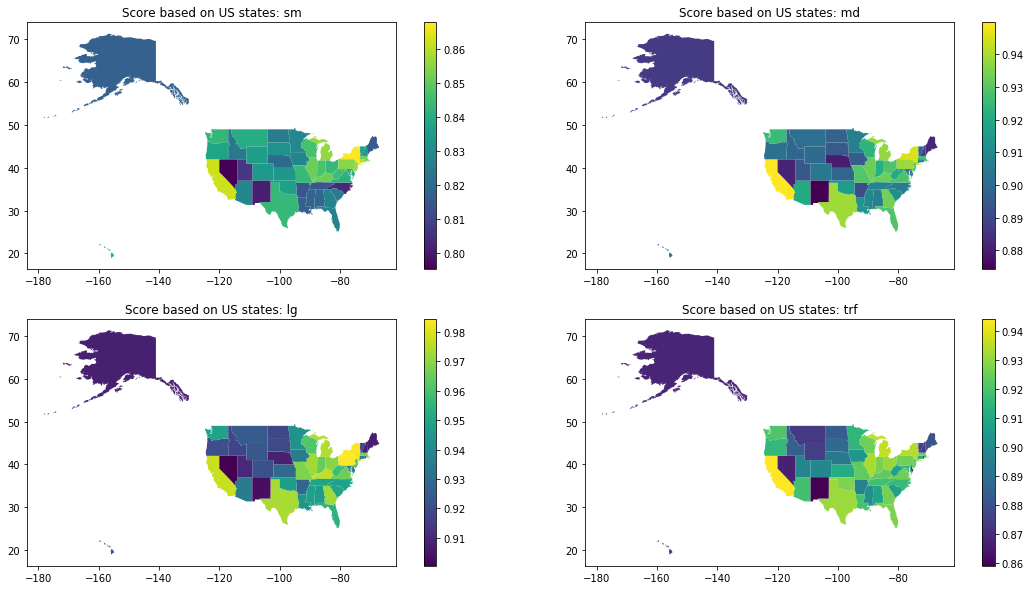

In [81]:
fig, axs = plt.subplots(2,2, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.001)

axs = axs.ravel()

for i in range(4):
    model = ['sm','md','lg','trf'][i]
    
    #Defining the figure:
    axs[i].set_title('Score based on US states: ' + model)
    gdf_states.plot(column='score_'+model, legend=True, ax = axs[i])
       
plt.savefig('images/results/score_each_models_first_names_us_state.png', bbox_inches='tight')
plt.show()

And on average:

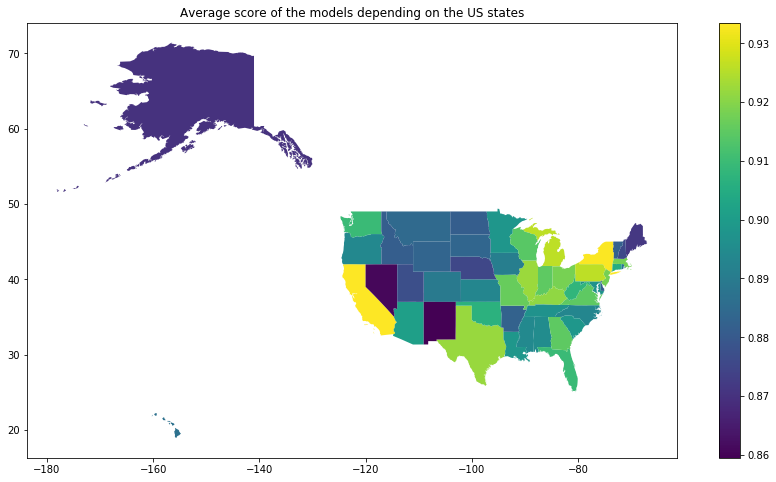

In [82]:
gdf_states.plot(column='avg_score', legend=True, figsize=(15,8))
plt.title('Average score of the models depending on the US states')
plt.savefig('images/results/avg_scoremap_us_states.png', bbox_inches='tight')
plt.show()

List of the best results:

In [83]:
for i in ['score_sm', 'score_md', 'score_lg','score_trf', 'avg_score']:
    print(i)
    print('--------')
    print(gdf_states.sort_values(i, ascending=False)[['state_name', i]].head(5).reset_index(drop=True))
    print('-----')

score_sm
--------
    state_name  score_sm
0     New York  0.867732
1   California  0.862219
2  Connecticut  0.860133
3     Michigan  0.855829
4   New Jersey  0.855307
-----
score_md
--------
     state_name  score_md
0    California  0.949851
1      New York  0.945313
2         Texas  0.939170
3  Pennsylvania  0.938889
4      Michigan  0.937615
-----
score_lg
--------
     state_name  score_lg
0  Pennsylvania  0.984500
1      New York  0.984188
2    California  0.977455
3      Kentucky  0.976437
4      Michigan  0.974614
-----
score_trf
--------
   state_name  score_trf
0  California   0.944359
1    Michigan   0.936551
2    New York   0.934374
3    Illinois   0.933204
4       Texas   0.931402
-----
avg_score
--------
     state_name  avg_score
0    California   0.933471
1      New York   0.932902
2  Pennsylvania   0.926166
3      Michigan   0.926152
4      Illinois   0.922486
-----


On average:

In [84]:
gdf_states.sort_values('avg_score', ascending=False)[['state_name', 'avg_score']].head(15).reset_index(drop=True)

,state_name,avg_score
0,California,0.933471
1,New York,0.932902
2,Pennsylvania,0.926166
3,Michigan,0.926152
4,Illinois,0.922486
5,Texas,0.921947
6,Kentucky,0.921155
7,Ohio,0.918291
8,New Jersey,0.918130
9,Massachusetts,0.917877


#### comparing to median household income by state:

[Source of the dataset](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html)

In [85]:
df_income = pd.read_excel('Data/median_income_us.xls', sheet_name='h08', header = 8, nrows=52)

In [86]:
df_income = df_income[['State', '2020_Median income']]

In [87]:
df_income.tail()

,State,2020_Median income
47,Virginia,81947
48,Washington,81083
49,West Virginia,51615
50,Wisconsin,67094
51,Wyoming,65108


In [88]:
gdf_states_income = gpd.read_file('Data/States 21basic.geojson')

In [89]:
del gdf_states_income['state_fips']
del gdf_states_income['drawseq']
del gdf_states_income['sub_region']

In [90]:
gdf_states_income.head()

,state_abbr,state_name,geometry
0,HI,Hawaii,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,WA,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,MT,Montana,"MULTIPOLYGON (((-111.47543 44.70216, -111.4808..."
3,ME,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,ND,North Dakota,"MULTIPOLYGON (((-98.73044 45.93827, -99.00683 ..."


In [91]:
gdf_states_income = gdf_states_income.merge(df_income, right_on='State', left_on='state_name', how='right')

In [92]:
gdf_states_income.isna().sum()

state_abbr            1
state_name            1
geometry              1
State                 0
2020_Median income    0
dtype: int64

In [93]:
gdf_states_income.dropna(inplace=True)

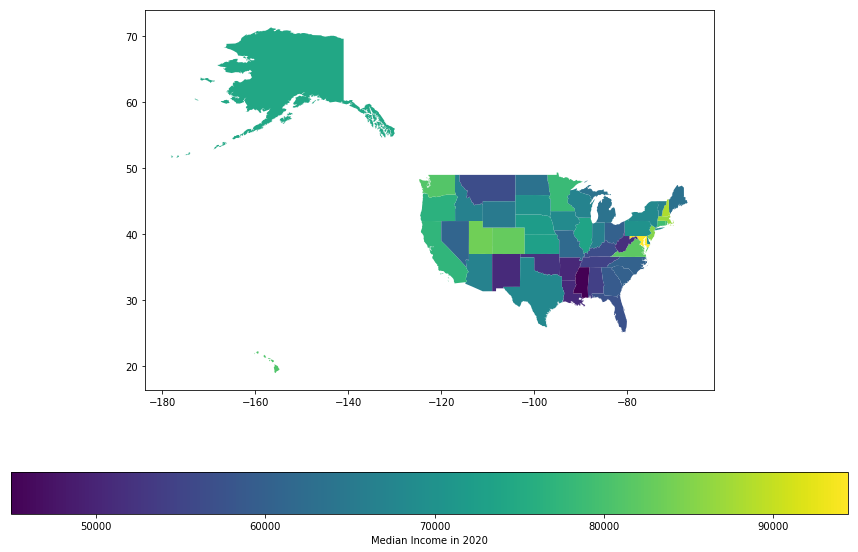

In [94]:
gdf_states_income.plot(column='2020_Median income', legend=True, figsize=(15,10),
                legend_kwds={'label': "Median Income in 2020",
                        'orientation': "horizontal"})
plt.show()

#### Correlation

In [95]:
gdf_states_income.head()

,state_abbr,state_name,geometry,State,2020_Median income
1,AL,Alabama,"MULTIPOLYGON (((-85.07007 31.98070, -85.11515 ...",Alabama,54393
2,AK,Alaska,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",Alaska,74476
3,AZ,Arizona,"MULTIPOLYGON (((-114.52063 33.02771, -114.5590...",Arizona,66628
4,AR,Arkansas,"MULTIPOLYGON (((-94.46169 34.19677, -94.45262 ...",Arkansas,50540
5,CA,California,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",California,77358


In [96]:
gdf_states.head()

,state_abbr,state_name,geometry,state,score_sm,score_md,score_lg,score_trf,avg_score
0,NY,New York,"MULTIPOLYGON (((-79.76324 42.26733, -79.44402 ...",NY,0.867732,0.945313,0.984188,0.934374,0.932902
1,CA,California,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",CA,0.862219,0.949851,0.977455,0.944359,0.933471
2,TX,Texas,"MULTIPOLYGON (((-105.99889 31.39394, -106.2132...",TX,0.843756,0.939170,0.973460,0.931402,0.921947
3,IL,Illinois,"MULTIPOLYGON (((-88.07159 37.51104, -88.08791 ...",IL,0.851554,0.932735,0.972451,0.933204,0.922486
4,AL,Alabama,"MULTIPOLYGON (((-85.07007 31.98070, -85.11515 ...",AL,0.818952,0.905997,0.946389,0.908916,0.895063


In [97]:
gdf_states.merge(gdf_states_income, left_on='state_abbr', right_on='state_abbr', how='right').corr()

,score_sm,score_md,score_lg,score_trf,avg_score,2020_Median income
score_sm,1.000000,0.698076,0.613669,0.465425,0.739558,0.403342
score_md,0.698076,1.000000,0.947525,0.838910,0.971704,0.011807
score_lg,0.613669,0.947525,1.000000,0.865585,0.965277,-0.108381
score_trf,0.465425,0.838910,0.865585,1.000000,0.903838,-0.007424
avg_score,0.739558,0.971704,0.965277,0.903838,1.000000,0.055363
2020_Median income,0.403342,0.011807,-0.108381,-0.007424,0.055363,1.000000


In [98]:
gdf_states_median = gdf_states.merge(gdf_states_income, left_on='state_abbr', right_on='state_abbr', how='right')

C:\Users\adrie\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:25

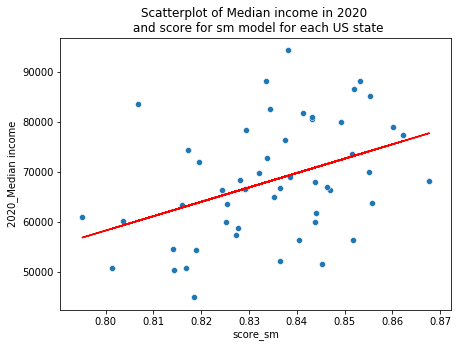

In [100]:
#Defining x and y:
x=gdf_states_median['score_sm']
y=gdf_states_median['2020_Median income']

plt.figure(figsize=(7,5))
sns.scatterplot(x,y)
plt.title('Scatterplot of Median income in 2020 \n and score for sm model for each US state')
#computing the correlation:
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='r')
plt.savefig('images/results/plot_correlation_sm_median_income.png', bbox_inches='tight')
plt.show()

#### Correlation gdp per state ???

Source : https://data.world/gmoney/gdp-per-capita-by-state

In [101]:
df_gdp = pd.read_excel('Data/GDP/state gdp per capita.xls')

In [102]:
df_gdp.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [103]:
df_gdp = df_gdp.merge(gdf_states, left_on='state', right_on='state_name', how='left').copy()

In [104]:
df_gdp[['2015', 'score_sm', 'score_md', 'score_lg', 'score_trf', 'avg_score']].corr().style.background_gradient(cmap='PiYG')

,2015,score_sm,score_md,score_lg,score_trf,avg_score
2015,1.000000,0.334777,-0.022845,-0.058949,-0.064227,0.029803
score_sm,0.334777,1.000000,0.698076,0.613669,0.465425,0.739558
score_md,-0.022845,0.698076,1.000000,0.947525,0.838910,0.971704
score_lg,-0.058949,0.613669,0.947525,1.000000,0.865585,0.965277
score_trf,-0.064227,0.465425,0.838910,0.865585,1.000000,0.903838
avg_score,0.029803,0.739558,0.971704,0.965277,0.903838,1.000000


In [105]:
df_gdp.dropna(inplace=True)

C:\Users\adrie\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:25

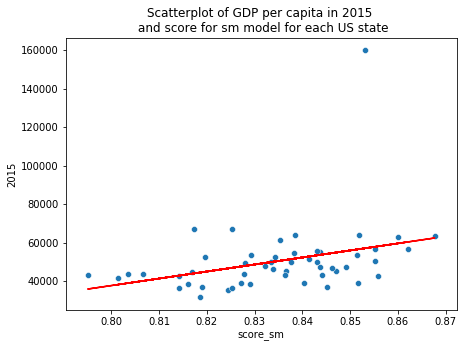

In [108]:
#Defining x and y:
x=df_gdp['score_sm']
y=df_gdp['2015']

plt.figure(figsize=(7,5))
sns.scatterplot(x,y)
plt.title('Scatterplot of GDP per capita in 2015 \n and score for sm model for each US state')
#computing the correlation:
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='r')
plt.savefig('images/results/plot_correlation_sm_GDP_per_capita.png', bbox_inches='tight')
plt.show()

## First names of people working at HuggingFace

Following our results and assumption, we can try to check if the first names of people working at HuggingFace have better results than on other first names. 

The list of team members is available [here](https://huggingface.co/huggingface). 

We can try to write a code that gets the first names and then apply the algorithms and compare the results. 

### Getting the data

#### First names of hugging face team members

In [109]:
import requests
from bs4 import BeautifulSoup

In [110]:
URL = "https://huggingface.co/huggingface"

source_code = requests.get(URL)
plain_text = source_code.content
soup = BeautifulSoup(plain_text, "lxml")

#We are searching for all the images in the page:
results = soup.find_all("img")

In [111]:
#constructing the list of the first names:
liste_first_names_hugg=[r.get('title') for r in results]
#Some images are not people:
liste_first_names_hugg = liste_first_names_hugg[2:]
liste_first_names_hugg = liste_first_names_hugg[:-11]

#We are only taking the first word:
liste_first_names_hugg = [fn.split()[0] for fn in liste_first_names_hugg]
#Only selecting what can be considered as a first name:
liste_first_names_hugg = [fn for fn in liste_first_names_hugg if fn not in ["🤗","AutoNLP", "Bibi", "Rob"]]

In [112]:
#Modifying the first names to have them in the proper shape:
liste_first_names_hugg = [fn.strip() for fn in liste_first_names_hugg]

In [113]:
print('len: {}'.format(len(liste_first_names_hugg)))
print('n unique: {}'.format(len(np.unique(liste_first_names_hugg))))

len: 61
n unique: 55


In [114]:
#Getting only unique first names: 
arr_first_names_hugg = np.unique(liste_first_names_hugg)

In [115]:
arr_first_names_hugg

array(['Abhishek', 'Adrien', 'Albert', 'Ali', 'Anna', 'Anthony', 'Anton',
       'Canwen', 'Charles', 'Colin', 'Ella', 'Federico', 'Gloria', 'Hugo',
       'Jeff', 'Julien', 'Kristina', 'Kunal', 'Leandro', 'Lewis', 'Luc',
       'Lucile', 'Lysandre', 'Margaret', 'Mario', 'Mark', 'Matthew',
       'Merve', 'Michael', 'Mishig', 'Morgan', 'Nate', 'Nicholas',
       'Nicolas', 'Niels', 'Nils', 'Omar', 'Patrick', 'Philipp',
       'Pierric', 'Quentin', 'Sasha', 'Siddharth', 'Simon', 'Stas',
       'Steven', 'Suraj', 'Suzana', 'Sylvain', 'Teven', 'Thibault',
       'Thomas', 'Victor', 'Violette', 'Yacine'], dtype='<U9')

#### Random first names from US Baby names

We are using the US Baby names dataset at the national level again. 

In [116]:
df_us_hugg = df_us_names.groupby(['Name']).sum().reset_index()
del df_us_hugg['Year']

#Sorting by count:
df_us_hugg = df_us_hugg.sort_values('Count').reset_index(drop=True)

In [117]:
#What is the count of each hugging face first names in the US baby names dataset?
df_us_hugg[df_us_hugg['Name'].isin(arr_first_names_hugg)].tail()

,Name,Count
93867,Anthony,1410142
93873,Matthew,1558671
93878,Thomas,2291517
93879,Charles,2376700
93885,Michael,4330805


In [118]:
df_us_hugg.iloc[93884]

Name        Mary
Count    4130441
Name: 93884, dtype: object

We can select first names based on their counts, instead of just slecting them randomly.

1. We delete the first names of hugging face 
2. For each, we select the first name just before (index-wise)


We are also only taking first names of hugging also in the US baby names dataset

In [119]:
df_us_not_hugg = df_us_hugg[~df_us_hugg['Name'].isin(arr_first_names_hugg)]

In [120]:
liste_names_us_not_hugg = []
for index, row in df_us_hugg[df_us_hugg['Name'].isin(arr_first_names_hugg)].iterrows():
    name=''
    while name=='':
        try:
            name = df_us_not_hugg.loc[index+1]['Name']
        except: 
            index+=1
    liste_names_us_not_hugg.append(name)

In [121]:
np.unique(liste_names_us_not_hugg).shape

(50,)

In [122]:
len(liste_names_us_not_hugg)

51

In [123]:
#'Richard is here two times because 'Thomas' and 'Charles' have indexes following each other


#WE are going to deal with that later

In [124]:
us_names_sample_hugg = np.array(liste_names_us_not_hugg)

In [125]:
arr_comparing_hugg_and_general = np.concatenate((arr_first_names_hugg, us_names_sample_hugg))

In [126]:
arr_comparing_hugg_and_general

array(['Abhishek', 'Adrien', 'Albert', 'Ali', 'Anna', 'Anthony', 'Anton',
       'Canwen', 'Charles', 'Colin', 'Ella', 'Federico', 'Gloria', 'Hugo',
       'Jeff', 'Julien', 'Kristina', 'Kunal', 'Leandro', 'Lewis', 'Luc',
       'Lucile', 'Lysandre', 'Margaret', 'Mario', 'Mark', 'Matthew',
       'Merve', 'Michael', 'Mishig', 'Morgan', 'Nate', 'Nicholas',
       'Nicolas', 'Niels', 'Nils', 'Omar', 'Patrick', 'Philipp',
       'Pierric', 'Quentin', 'Sasha', 'Siddharth', 'Simon', 'Stas',
       'Steven', 'Suraj', 'Suzana', 'Sylvain', 'Teven', 'Thibault',
       'Thomas', 'Victor', 'Violette', 'Yacine', 'Chubby', 'Brendell',
       'Derak', 'Ettamae', 'Alveria', 'Nadra', 'Nichols', 'Brynleigh',
       'Carrissa', 'Zephyr', 'Audria', 'Vasilios', 'Clover', 'Calla',
       'Ludie', 'Donta', 'Tremayne', 'Maybelle', 'Tylor', 'Rico',
       'Lisette', 'Alivia', 'Dick', 'Kira', 'Jayla', 'Dewey', 'Lesley',
       'Cecelia', 'Josiah', 'Jenny', 'Harvey', 'Tonya', 'Melinda',
       'Jenna', 'Carmen'

### Applying the models

In [50]:
df_results_hugg = main_ner_first_names(100000, arr_comparing_hugg_and_general)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:15<00:00, 180.09it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:58<00:00, 151.86it/s]


Testing the model: lg


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:56<00:00, 167.59it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:36:20<00:00, 17.30it/s]


In [127]:
#df_results_hugg.to_csv('data/results/first_names/df_results_hugg_100000.csv', index=False)
df_results_hugg= pd.read_csv('data/results/first_names/df_results_hugg_100000.csv')

### Results

In [128]:
df_hugg = pd.DataFrame(data={'name':arr_first_names_hugg, 'huggingface':True})
df_non_hugg = pd.DataFrame(data={'name':us_names_sample_hugg, 'huggingface':False})

In [129]:
df_test_hugg = pd.concat([df_hugg, df_non_hugg]).reset_index()

In [130]:
df_results_hugg.head()

,name,score_sm,score_md,score_lg,score_trf
0,Abhishek,0.988292,0.908402,0.677686,0.693182
1,Adrien,0.929636,1.000000,1.000000,0.867938
2,Albert,1.000000,0.999656,1.000000,0.956342
3,Alivia,1.000000,0.977334,1.000000,0.813599
4,Alveria,0.711911,0.977839,0.528393,0.815097


In [131]:
df_results_ = df_results_hugg.merge(df_test_hugg, left_on='name', right_on='name', how='left')
df_results_ = df_results_.groupby('huggingface').mean()

In [134]:
df_results_[['score_sm', 'score_trf']].style.background_gradient(cmap='PiYG')

,score_sm,score_trf
huggingface,,
False,0.745748,0.877733
True,0.734776,0.897385


We can clearly see that for first names with same popularity, trf recognizes bette (2 points difference) the first names of people working at HuggingFace than others. 

Morover, it is not the case for the sm model. 